## 1. Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab 
from pylab import *
pylab.rcParams['figure.figsize'] = (16, 6) # size for all figures

## 2. Data Preprocessing

In [22]:
df = pd.read_csv('WTI_DATA.csv',parse_dates=True,index_col='DATE') # parsing the date column as datetime type and setting as index

Note: the above code is a faster way of doing the following:
<pre>df = pd.read_csv('WTI_DATA.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('Date',inplace=True)</pre>

In [23]:
df.columns = ['WTI'] # Renaming the Column for easier use

In [24]:
df.head()

,WTI
DATE,
1986-01-01,22.93
1986-02-01,15.46
1986-03-01,12.61
1986-04-01,12.84
1986-05-01,15.38


In [25]:
df.index

DatetimeIndex(['1986-01-01', '1986-02-01', '1986-03-01', '1986-04-01',
               '1986-05-01', '1986-06-01', '1986-07-01', '1986-08-01',
               '1986-09-01', '1986-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='DATE', length=415, freq=None)

In order to build time series models, we need to specify the frequency of the data. Since the observations occur at the start of the month, we will use MS (Monthly Start)

In [26]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1986-01-01', '1986-02-01', '1986-03-01', '1986-04-01',
               '1986-05-01', '1986-06-01', '1986-07-01', '1986-08-01',
               '1986-09-01', '1986-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='DATE', length=415, freq='MS')

#### We can see that our index consists of datetime64 type which is what we need for Time Series Analysis

In [27]:
print(f'The monthly data consists of values from {df.index.min()} to {df.index.max()}')

The monthly data consists of values from 1986-01-01 00:00:00 to 2020-07-01 00:00:00


## 3. Exploratory Data Analysis (EDA)

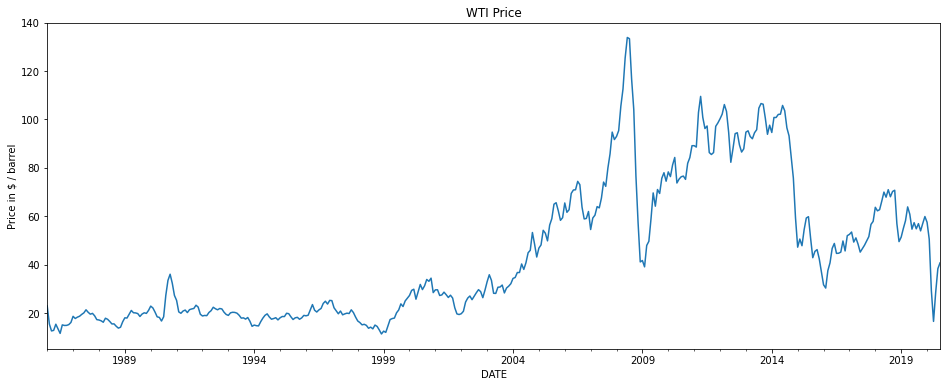

In [28]:
df['WTI'].plot(title='WTI Price',figsize=(16,6)).autoscale(axis='x',tight=True)
plt.ylabel('Price in $ / barrel');

#### Rolling Window

In [29]:
df['5 Month Mean'] = df['WTI'].rolling(window=5).mean() # Rolling mean with window size = 30

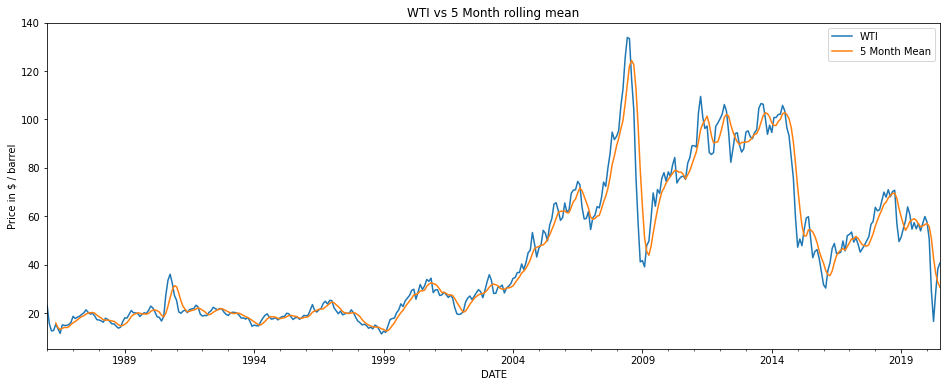

In [30]:
df[['WTI','5 Month Mean']].plot(figsize=(16,6),title='WTI vs 5 Month rolling mean')
plt.ylabel('Price in $ / barrel');

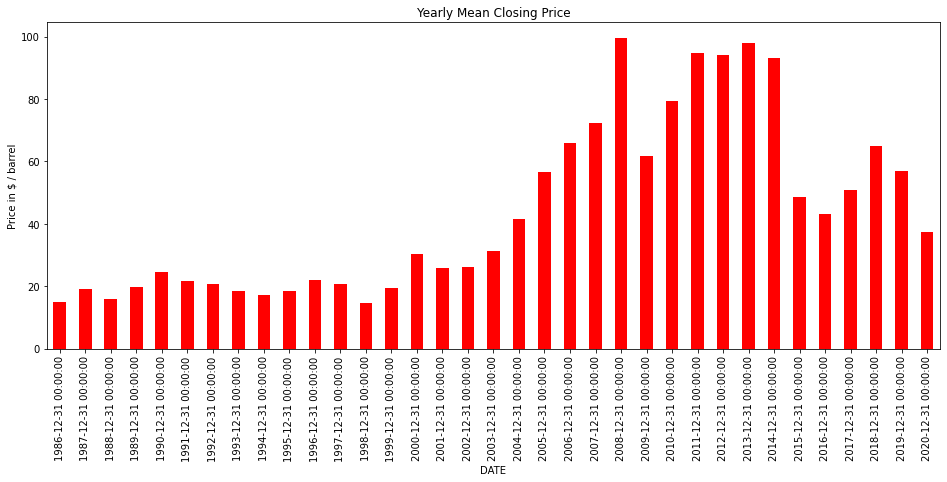

In [32]:
df['WTI'].resample(rule='A').mean().plot.bar(figsize=(16,6),title='Yearly Mean Closing Price',color='red')
plt.ylabel('Price in $ / barrel');

By resampling based on the time series index, and then aggregating based on chosen rule (offset alias), various insights on the data can be found

#### Hodrick-Prescott Filter

In [33]:
from statsmodels.tsa.filters.hp_filter import hpfilter # Hodrick-Prescott filter seperates time series into trend and cyclic part

wti_cycle,wti_trend = hpfilter(df['WTI'],lamb=14400) # lambda-> 100*(number of periods in a year)^2

df['Trend'] = wti_trend

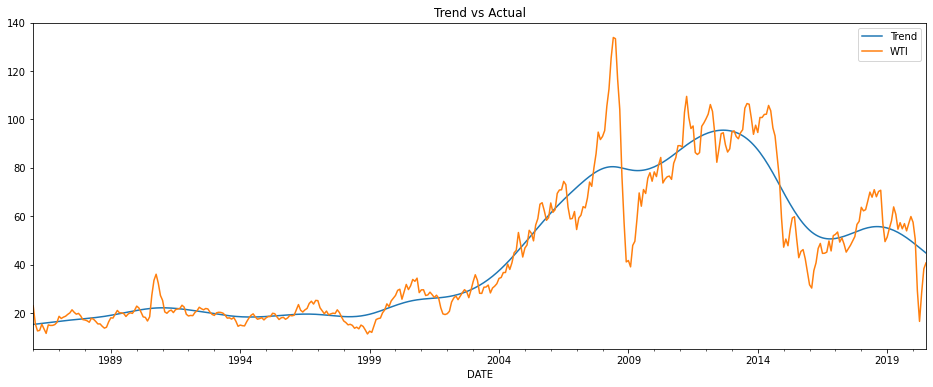

In [34]:
df[['Trend','WTI']].plot(title='Trend vs Actual',figsize=(16,6)).autoscale(axis='x',tight=True);

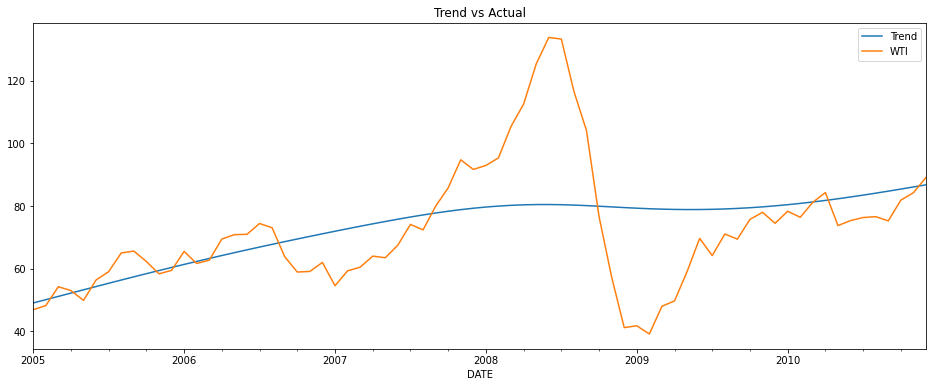

In [35]:
df[['Trend','WTI']]['2005':'2010'].plot(title='Trend vs Actual',figsize=(16,6)).autoscale(axis='x',tight=True);

We can see from these numbers that during the 2008 market crash, the actual price did not follow the trend, and that is a major disadvantage of the hpfilter

#### ETS Decomposition

The decomposition of a time series attempts to isolate individual components such as error, trend and seasonlaity.

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
ets = seasonal_decompose(df['WTI'],model='add') # multiplicative/non-linear trend 

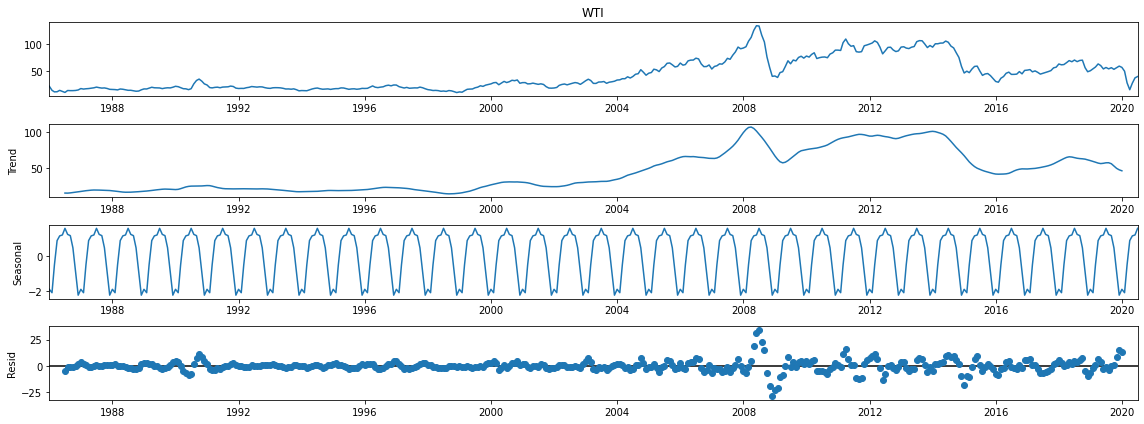

In [40]:
ets.plot();

#### Train-Test Split

In [58]:
len(df) - 18 # Finding the split point index to keep 1.5 years (18 months) data as test set

397

In [59]:
train_data = df.iloc[:397]
test_data = df.iloc[397:]

## 4. Forecasting Models

#### a) Holt-Winters

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['WTI'],trend='add',seasonal='add',seasonal_periods=12).fit() # keeping seasonality = 1 year

/Users/vasusingh/opt/anaconda3/envs/time-series/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [63]:
test_predictions = fitted_model.forecast(18).rename('Holt-Winters Forecast')

In [64]:
test_predictions

2019-02-01    52.641058
2019-03-01    54.837805
2019-04-01    56.890902
2019-05-01    55.827199
2019-06-01    54.234725
2019-07-01    54.373908
2019-08-01    52.364891
2019-09-01    52.073094
2019-10-01    50.425614
2019-11-01    47.206540
2019-12-01    46.764248
2020-01-01    47.810696
2020-02-01    49.161362
2020-03-01    51.358109
2020-04-01    53.411206
2020-05-01    52.347503
2020-06-01    50.755029
2020-07-01    50.894212
Freq: MS, Name: Holt-Winters Forecast, dtype: float64

In [65]:
compare = pd.DataFrame()

In [66]:
compare['Actual'] = test_data['WTI']
compare['Forecast'] = test_predictions

In [67]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(compare['Actual'],compare['Forecast'])

9.516889819490952

On average, for our test months, we get an absolute error of around 10$/barrerl